Enter picture name: test.png
0  -  All
1  -  Brighten
2  -  Contrast
3  -  Flip
4  -  Grey
5  -  Overlap
6  -  Blur
7  -  Circle Frame
8  -  Ellipse Frame
Choose options: 0
Image's size:  (4032, 3024, 3)
Option:  1 - Brighten


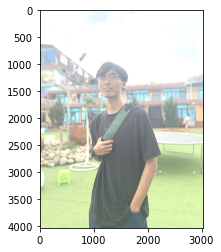

Image's size:  (4032, 3024, 3)
Option:  2 - Contrast


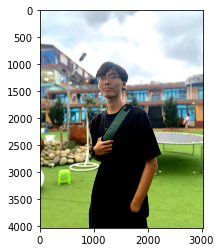

0 - Flip Vertically
1 - Flip Horizontally
Choose options: 0
Image's size:  (4032, 3024, 3)
Option:  3 - Flip


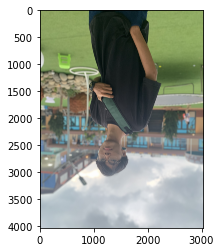

Image's size:  (4032, 3024, 3)
Option:  4 - Grey


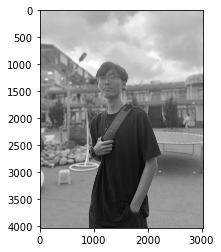

Enter another picture name to overlap: test.png
Image's size:  (4032, 3024, 3)
Option:  5 - Overlap


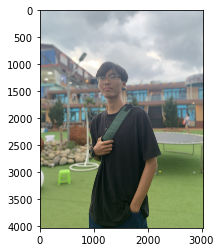

Image's size:  (4032, 3024, 3)
Option:  6 - Blur


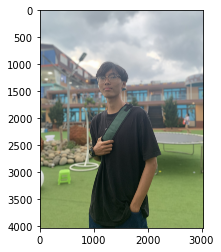

Image's size:  (4032, 3024, 3)
Option:  7 - Circle Frame


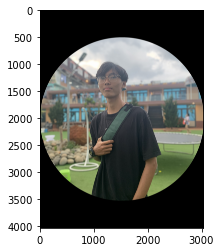

Image's size:  (4032, 3024, 3)
Option:  8 - Ellipse Frame


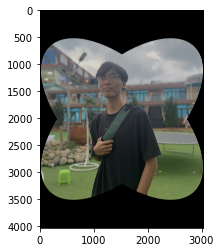

In [233]:
'''

Name: Lai Minh Thong
Student ID: 20127635

---Image Processing---
1) Brighten
2) Contrast
3) Flip
4) Grey
5) Overlap
6) Blur
7) Circle Frame
8) Ellipse Frame
    
'''

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import math



def brightenImage(image, scale = 0.3):
    image = image.astype(int)
    
    #increase image with a predefined scale
    image += int(scale*255)
    image[image > 255] = 255
    
    image = image.astype(np.uint8)
    return image

def contrastImage(image, scale = 0.3):
    image = image.astype(float)
    
    #scale domain of RGB values from 0->255 to -0.5->0.5
    image = image/255 - 0.5
    
    image *= float(1 + scale)**2
    
    #scale domain of RGB values back
    image = (image + 0.5) * 255
    
    image[image > 255] = 255
    image[image < 0] = 0
    
    image = image.astype(np.uint8)
    return image

def flipImage(image, dim, mode):
    image = image.reshape(dim)
    
    image = np.flip(image, mode)
    
    image = image.flatten()
    return image

def greyImage(image, alpha = 0.299, beta = 0.587, gamma = 0.114):
    image = image.astype(float)
    
    image = np.dot(image, np.array([alpha, beta, gamma])/(alpha + beta + gamma))
    image = (image*np.ones((3,1))).transpose()
    
    image = image.astype(np.uint8)
    return image

def overlapImage(image1, image2, alpha = 1, beta = 1):
    image1 = image1.astype(float)
    image2 = image2.astype(float)
    
    image = (image1*alpha + image2*beta)/(alpha + beta)
    
    image = image.astype(np.uint8)
    return image

def blurImage(image, dim, kernel):
    image = image.reshape(dim)
    image_result = np.zeros(image.shape)
    
    kernelDim = kernel.shape[0]
    for i in range(kernelDim):
        for j in range(kernelDim):
            rowShiftValue = int(i - kernelDim/2)
            colShiftValue = int(j - kernelDim/2)
            shiftedArray = np.roll(image, (rowShiftValue, colShiftValue), axis=(0, 1))
            image_result += shiftedArray * kernel[i,j]
        
    image_result = image_result.flatten()
    
    image_result = image_result.astype(np.uint8)
    return image_result

def circleFrame(image, dim, mode = 0):
    image = image.reshape(dim)
    
    height = dim[0]
    width = dim[1]
    
    center = np.array([height/2, width/2])
    radius = mode*max(height/2, width/2) + (1 - mode)*min(height/2, width/2)
        
    x, y = np.ogrid[:height, :width]
                      
    mask_circle = (x - center[0])**2 + (y - center[1])**2 > radius**2
    image[mask_circle] = np.zeros(dim[2])
                      
    image = image.flatten()
    return image
    
def interlaceEllipseFrame(image, dim, scale = 1.25, angle = 45):
    image = image.reshape(dim)
    
    height = dim[0]
    width = dim[1]
    
    #Create parameters for rotation
    angle = math.radians(angle)
    sine = math.sin(angle)
    cosine = math.cos(angle)

    #Define edge of the ellipse picture
    edge = int(min(width, height)*scale)
    #Define new edge after rotation of the ellipse picture
    new_edge  = np.ceil(abs(edge * cosine) + abs(edge * sine)).astype(int)
    
    
    #Create 2 ellips mask
    x_ellips, y_ellips = np.ogrid[:edge, :edge]
    smallRadius = edge/4
    largeRadius = edge/2
    
    mask_ellips1 = (x_ellips-edge/2)**2/largeRadius**2 + (y_ellips-edge/2)**2/smallRadius**2 > 1
    mask_ellips2 = (x_ellips-edge/2)**2/smallRadius**2 + (y_ellips-edge/2)**2/largeRadius**2 > 1
    mask_ellips = mask_ellips1 & mask_ellips2
    


    #Find new location corresponding to each x_ellips, y_ellips
    y = edge/2 - y_ellips               
    x = edge/2 - x_ellips
    x_new = (new_edge/2 - np.ceil(x*cosine + y*sine)).astype(int)
    y_new = (new_edge/2 - np.ceil(-x*sine + y*cosine)).astype(int)

    
    #Convert to new rotatedMask
    rotatedMask_ellips = np.ones((new_edge, new_edge), dtype = bool)
    rotatedMask_ellips[x_new, y_new] = mask_ellips[x_ellips, y_ellips]
    
    
    #Cut out the excess and broadcast to fit the image
    c = int(np.ceil((rotatedMask_ellips.shape[0] - width)/2))
    rotatedMask_ellips = rotatedMask_ellips[c:-c, c:-c]

    temp = np.ones((height, width), dtype=bool)
    startIndexH = int((height - rotatedMask_ellips.shape[0])/2)
    startIndexW = int((width - rotatedMask_ellips.shape[1])/2)
    temp[startIndexH:rotatedMask_ellips.shape[0]+startIndexH,startIndexW:rotatedMask_ellips.shape[1]+startIndexW] = rotatedMask_ellips
    rotatedMask_ellips = temp
    
    
    #Mask with the image
    image[rotatedMask_ellips] = np.zeros(dim[2])
    
    image = image.flatten()
    return image

def save_image(opt, imName, image):
    image = Image.fromarray(image)
      
    if opt == 1:
        image.save(imName[:-4] + "_brighten" + imName[-4:])
    elif opt == 2:
        image.save(imName[:-4] + "_contrast" + imName[-4:])
    elif opt == 3:
        image.save(imName[:-4] + "_flip" + imName[-4:])
    elif opt == 4:
        image.save(imName[:-4] + "_grey" + imName[-4:])
    elif opt == 5:
        image.save(imName[:-4] + "_overlap" + imName[-4:])
    elif opt == 6:
        image.save(imName[:-4] + "_blur" + imName[-4:])
    elif opt == 7:
        image.save(imName[:-4] + "_roundFrame" + imName[-4:])
    elif opt == 8:
        image.save(imName[:-4] + "_ellipseFrame" + imName[-4:])

def show_image(optIndex, converted_image, Options):
    print("Image's size: ", converted_image.shape)
    print("Option: ", optIndex, "-", Options[optIndex])
    plt.imshow(converted_image)
    plt.show()
    
def generate_image(optIndex, image):
    #Convert into np.array
    image = np.array(image)
    dim = image.shape
    
    #Flatten image into 1d and reshape into an array of pixels elements
    image = image.flatten()
    image = image.reshape(int(image.shape[0]/3), 3)
    
    
    #Brighten    
    if optIndex == 1: 
        converted_image = brightenImage(image)
        
    #Contrast
    elif optIndex == 2:
        converted_image = contrastImage(image)
        
    #Flip
    elif optIndex == 3:
        mode = 0
        while True:
            print("0 - Flip Vertically")
            print("1 - Flip Horizontally")      
            mode = int(input("Choose options: "))
            if mode == 0 or mode == 1:
                  break
        
        converted_image = flipImage(image, dim, mode)
        
    #Grey
    elif optIndex == 4:
        converted_image = greyImage(image)
        
    #Overlap
    elif optIndex == 5:
        imNameOverlap = input("Enter another picture name to overlap: ")
        imageOverlap = Image.open(imNameOverlap, 'r')
        imageOverlap = np.array(imageOverlap)
        
        imageOverlap = imageOverlap.flatten()
        imageOverlap = imageOverlap.reshape(int(imageOverlap.shape[0]/3), 3)
        
        converted_image = overlapImage(image, imageOverlap)
        
    #Blur
    elif optIndex == 6:
        #Define Kernel's values
#         kernel = np.array([[1, 2, 1], 
#                            [2, 4, 2], 
#                            [1, 2, 1]])
        kernel = np.array([[1, 4,  6,  4,  1], 
                           [4, 16, 24, 16, 4], 
                           [4, 26, 36, 26, 4], 
                           [4, 16, 24, 16, 4], 
                           [1, 4,  6,  4,  1]])
        kernel = kernel / np.sum(kernel)
        
        converted_image = blurImage(image, dim, kernel)
        
    #Circle Frame
    elif optIndex == 7:
        converted_image = circleFrame(image, dim) 
    
    #Ellipse Frame
    elif optIndex == 8:
        converted_image = interlaceEllipseFrame(image, dim)
        
    #Reshape back into image's dimension 
    converted_image = converted_image.reshape(dim)
    
    return converted_image
    
    
        
def main():
    Options = [
        "All",
        "Brighten", 
        "Contrast", 
        "Flip",
        "Grey",
        "Overlap",
        "Blur",
        "Circle Frame",
        "Ellipse Frame"]
    
    imName = input("Enter picture name: ")
#     imName = "Lenna.png"
    
    #Menu
    for i in range(len(Options)):
        print(i, " - ", Options[i])
    optIndex = int(input("Choose options: "))
    image = Image.open(imName, 'r')
    
        
    #Convert image
    #All
    converted_image = np.array([])
    if optIndex == 0:
        for i in range(1, len(Options)):
            converted_image = generate_image(i, image)
            show_image(i, converted_image, Options)
            save_image(i, imName, converted_image)
    else:
        converted_image = generate_image(optIndex, image)
        show_image(optIndex, converted_image, Options)
        save_image(optIndex, imName, converted_image)
    
    
    
main()